In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import PipelineTS
PipelineTS.__version__

'0.3.6'

In [3]:
from PipelineTS.dataset import BuiltInSeriesData
bs = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [4]:
import pandas as pd
init_data = bs['Messages_Sent']

time_col = 'date'
target_col = 'ta'
lags = 60
n = 40
device = 'cpu'

init_data = init_data[[time_col, target_col]]
init_data[time_col] = pd.to_datetime(init_data[time_col])
init_data = init_data.sort_values(time_col).reset_index(drop=True)

In [5]:
valid_data = init_data.iloc[-n:, :]
data = init_data.iloc[:-n, :]
print("data shape: ", data.shape, ", valid data shape: ", valid_data.shape)
data.tail(5)

data shape:  (562, 2) , valid data shape:  (40, 2)


,date,ta
557,2021-07-11,125957
558,2021-07-12,139012
559,2021-07-13,127014
560,2021-07-14,118241
561,2021-07-15,114358


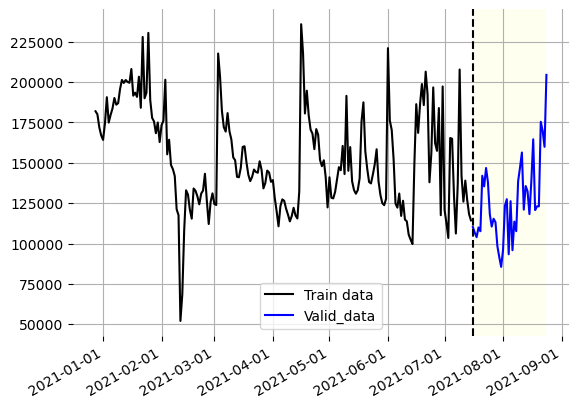

In [6]:
from PipelineTS.plot import plot_data_period
plot_data_period(
    data.iloc[-200:, :], 
    valid_data, 
    time_col=time_col, 
    target_col=target_col, 
    labels=['Train data', 'Valid_data'],
    # date_fmt='%Y-%m-%d %H:%M:%S'  # 支持指定时间格式
)

# PipelineTS

In [7]:
from PipelineTS.pipeline import ModelPipeline, PipelineConfigs

In [8]:
# list all models
ModelPipeline.list_all_available_models()

['auto_arima',
 'catboost',
 'lightgbm',
 'xgboost',
 'wide_gbrt',
 'd_linear',
 'n_linear',
 'n_beats',
 'n_hits',
 'tcn',
 'tft',
 'gau',
 'stacking_rnn',
 'time2vec',
 'multi_output_model',
 'multi_step_model',
 'transformer',
 'random_forest',
 'tide',
 'seg_rnn',
 'prophet']

In [9]:
# 如果希望一次性尝试模型的多个配置，以便进行比较或者调参，请使用PipelineConfigs
# 此功能允许自定义每个ModelPipeline.list_all_available_models()的模型，
# 包括模型初始化参数init_configs、模型拟合参数fit_configs、模型预测参数predict_configs

pipeline_configs = PipelineConfigs([
    ('multi_output_model', {'init_configs': {'verbose': -1}}),
    ('multi_step_model', {'init_configs': {'verbose': -1}}),
    # ('wide_gbrt', {
    #     'init_configs': {'linear_tree': True}
    #     }
    # ),
])

,model_name,model_name_with_index,model_configs
0,multi_output_model,multi_output_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"
1,multi_step_model,multi_step_model_1,"{'init_configs': {'verbose': -1}, 'fit_configs': {}, 'predict_configs': {}}"


In [10]:
from sklearn.metrics import mean_absolute_error
pipeline = ModelPipeline(
    time_col=time_col, 
    target_col=target_col, 
    lags=lags, 
    random_state=42, 
    metric=mean_absolute_error, 
    metric_less_is_better=True,
    configs=pipeline_configs,
    include_init_config_model=False,
    use_standard_scale=False,  # False for MinMaxScaler, True for StandardScaler, None means no data be scaled
    # include_models=['d_linear', 'random_forest', 'n_linear', 'n_beats'],  # specifying the model used
    # exclude_models=['catboost', 'tcn', 'transformer'],  # exclude specified models
    device=device
)

In [11]:
pipeline.fit(data, valid_data=valid_data)

17:07:11 2023-10-27 - PipelineTS - There are a total of 21 models to be trained.
17:07:11 2023-10-27 - PipelineTS - [model  0] fitting and evaluating auto_arima...
17:07:27 2023-10-27 - PipelineTS - [model  1] fitting and evaluating catboost...
17:09:29 2023-10-27 - PipelineTS - [model  2] fitting and evaluating d_linear...
17:09:43 2023-10-27 - PipelineTS - [model  3] fitting and evaluating gau...
17:10:06 2023-10-27 - PipelineTS - [model  4] fitting and evaluating lightgbm...
17:10:33 2023-10-27 - PipelineTS - [model  5] fitting and evaluating multi_output_model_1...
17:10:56 2023-10-27 - PipelineTS - [model  6] fitting and evaluating multi_step_model_1...
17:11:05 2023-10-27 - PipelineTS - [model  7] fitting and evaluating n_beats...
17:11:21 2023-10-27 - PipelineTS - [model  8] fitting and evaluating n_hits...
17:11:40 2023-10-27 - PipelineTS - [model  9] fitting and evaluating n_linear...
17:11:54 2023-10-27 - PipelineTS - [model 10] fitting and evaluating prophet...
17:12:03 2023

Leaderboard,model,train_cost(s),eval_cost(s),metric
0,n_beats,6.624887,0.047033,19584.698633
1,stacking_rnn,41.918303,0.008792,19603.507290
2,prophet,0.104706,0.053615,20629.311013
3,time2vec,57.479287,0.012575,24147.928603
4,seg_rnn,66.207022,0.016018,24704.488975
5,n_hits,9.534074,0.053380,25226.286719
6,tide,7.576207,0.034220,25339.908008
7,auto_arima,7.418804,0.022559,26842.097945
8,catboost,112.659390,0.068294,30901.968223
9,lightgbm,18.105856,0.060364,31030.781881


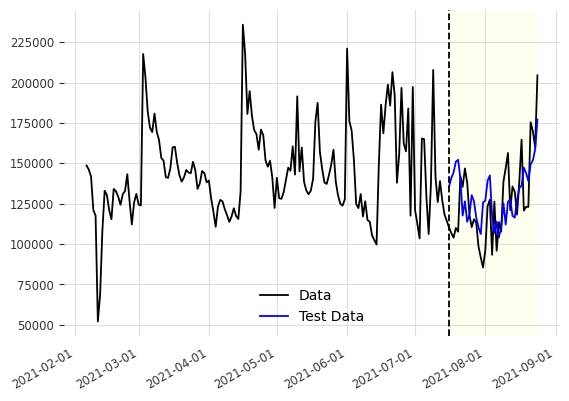

In [12]:
prediction = pipeline.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [13]:
# Gets all configurations for the specified model， default to best model
pipeline.get_model_all_configs()

{'model_configs': {'input_chunk_length': 60,
  'output_chunk_length': 60,
  'generic_architecture': False,
  'num_stacks': 30,
  'num_blocks': 1,
  'num_layers': 4,
  'layer_widths': 256,
  'expansion_coefficient_dim': 5,
  'trend_polynomial_degree': 2,
  'dropout': 0.0,
  'activation': 'ReLU',
  'loss_fn': MSELoss(),
  'torch_metrics': None,
  'optimizer_cls': torch.optim.adam.Adam,
  'optimizer_kwargs': None,
  'lr_scheduler_cls': None,
  'lr_scheduler_kwargs': None,
  'use_reversible_instance_norm': False,
  'batch_size': 32,
  'n_epochs': 100,
  'nr_epochs_val_period': 1,
  'add_encoders': None,
  'pl_trainer_kwargs': {'accelerator': 'cpu',
   'enable_progress_bar': False,
   'enable_model_summary': False},
  'random_state': 42},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'enable_progress_bar': False,
 'enable_model_summary': False}

## Model saving and reloading

In [14]:
from PipelineTS.io import *

In [15]:
save_model('pipeline.zip', pipeline)
pipeline2 = load_model('pipeline.zip')

In [16]:
pipeline2.best_model_

In [17]:
# Gets all configurations for the specified model， default to best model
pipeline2.get_model_all_configs()

{'model_configs': {'input_chunk_length': 60,
  'output_chunk_length': 60,
  'generic_architecture': False,
  'num_stacks': 30,
  'num_blocks': 1,
  'num_layers': 4,
  'layer_widths': 256,
  'expansion_coefficient_dim': 5,
  'trend_polynomial_degree': 2,
  'dropout': 0.0,
  'activation': 'ReLU',
  'loss_fn': MSELoss(),
  'torch_metrics': None,
  'optimizer_cls': torch.optim.adam.Adam,
  'optimizer_kwargs': None,
  'lr_scheduler_cls': None,
  'lr_scheduler_kwargs': None,
  'use_reversible_instance_norm': False,
  'batch_size': 32,
  'n_epochs': 100,
  'nr_epochs_val_period': 1,
  'add_encoders': None,
  'pl_trainer_kwargs': {'accelerator': 'cpu',
   'enable_progress_bar': False,
   'enable_model_summary': False},
  'random_state': 42},
 'lags': 60,
 'quantile': None,
 'time_col': 'date',
 'target_col': 'ta',
 'enable_progress_bar': False,
 'enable_model_summary': False}

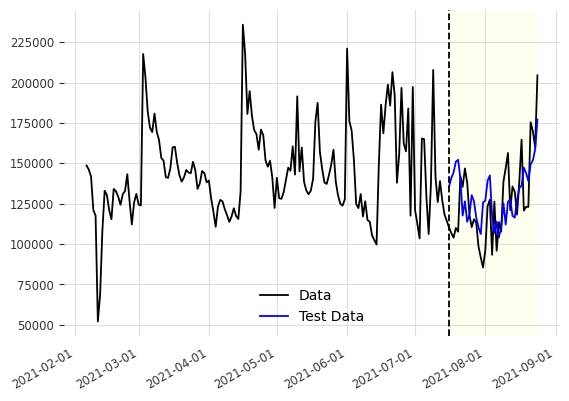

In [18]:
prediction = pipeline2.predict(n)

plot_data_period(init_data.iloc[-200:, :], prediction, 
                 time_col=time_col, target_col=target_col)